# Packages Used

In [914]:
import pandas as pd
import numpy as np
import gdown
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from numpy.linalg import LinAlgError
from scipy.spatial.distance import braycurtis
from sklearn.preprocessing import MinMaxScaler


# Loading Data

In [2]:
file_id = '1JjYmvA8qTPOh_dVAVkvsapP-xtes7F4h'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'spotify_songs.csv'
gdown.download(url, output, quiet=False)

songs = pd.read_csv('spotify_songs.csv')

Downloading...
From: https://drive.google.com/uc?id=1JjYmvA8qTPOh_dVAVkvsapP-xtes7F4h
To: c:\Users\pedro\OneDrive\Área de Trabalho\ISU\Fall 24\coding\final project\spotify_songs.csv
100%|██████████| 7.97M/7.97M [00:00<00:00, 17.7MB/s]


In [3]:
songs.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [4]:
rows,columns = songs.shape

print(f'Rows: {rows:,}\nColumns: {columns}')

Rows: 32,833
Columns: 23


# Preprocessing

## Identifying and Treating Nulls

In [5]:
songs.isna().sum()

track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

Only 5 instances of null values were found in the dataset. Since removing those nulls present no integrity concerns for the analysis or future processes involving the dataset, they will be removed from the dataset.

In [6]:
songs.dropna(inplace=True)

rows,columns = songs.shape

print(f'Rows: {rows:,}\nColumns: {columns}')

Rows: 32,828
Columns: 23


In [7]:
songs.isna().sum()

track_id                    0
track_name                  0
track_artist                0
track_popularity            0
track_album_id              0
track_album_name            0
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

## Identifying and Treating Duplicates

The initial idea was to use the unique identifier **track_id** to identify and treat duplicated songs. When this approach was attempted, it was verified that some tracks were still duplicated. A common reason for this phenomenon to happen was the fact that certain songs may have been part of more than one album, or may have been remastered more than once. In all instances, duplicated songs had the same main characteristics (e.g.: acousticness, speechiness, loudness, etc.), deeming irrelevant the identification of which instance should be removed from the dataset. The following shows the subset of duplicated **track_name** and **track_artist** values (unique songs) in the dataset:

In [8]:
songs[songs.duplicated(subset=['track_name','track_artist'])]

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
193,3BOcWxFUURAomDXRSDFve4,Something Real,Armin van Buuren,58,5cqwXF2j9LkvFInBFlnQd3,Balance,2019-10-25,Dance Room,37i9dQZF1DX2ENAPP1Tyed,pop,...,1,-4.578,1,0.0439,0.04460,0.000000,0.0693,0.232,127.922,179531
209,4TIkSdsNSfqpuq6ZYvCjAz,All You Need To Know (feat. Calle Lehmann),Gryffin,68,2IAVHJdaRPFA6MQqXHoG75,Gravity,2019-10-24,Dance Room,37i9dQZF1DX2ENAPP1Tyed,pop,...,0,-6.019,1,0.0376,0.00699,0.000000,0.1030,0.219,139.929,238338
232,3sHuIjfAzluc6S9cXoqfqC,Let It Be Me,Steve Aoki,23,5ocW53VBnOprl6EAMOLGet,Let It Be Me,2019-09-06,Cardio,37i9dQZF1DWSJHnPb1f0X3,pop,...,7,-5.299,1,0.0864,0.07970,0.000000,0.1060,0.387,114.098,224061
272,36orMWv2PgvnzXsd5CJ0yL,Post Malone (feat. RANI),Sam Feldt,75,45nsubB5EsRVWWqx0ED1ET,Post Malone (feat. RANI) [Joe Stone Remix],2019-08-16,Dance Pop Hits,37i9dQZF1DX6pH08wMhkaI,pop,...,7,-3.870,1,0.1220,0.07710,0.000000,0.1050,0.651,107.356,174444
294,7rpyHKSH3dkrsKEgv1eNgv,Woke Up Late (feat. Hailee Steinfeld) - Sam Fe...,Drax Project,56,5VW1WffQj2SqKUhwnNq1xJ,Woke Up Late (feat. Hailee Steinfeld) [Sam Fel...,2019-05-02,Dance Pop Hits,37i9dQZF1DX6pH08wMhkaI,pop,...,0,-3.753,1,0.0978,0.07170,0.000000,0.1080,0.499,122.055,196475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32799,5SMYN4lHZduUD8SQ0TEHj2,Ten Feet Tall,Afrojack,0,0DzZnIm8Em2tG8rG1co792,Ten Feet Tall,2014-01-01,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,0,-3.429,1,0.0639,0.03560,0.000000,0.1400,0.346,127.021,233353
32800,5yl2YyDgcpERTZoZHD9Etl,Dynamite,Gareth Emery,0,3Zm13AWIMBpJbwFzenqy9V,Drive,2014-04-01,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,5,-6.113,1,0.0312,0.01110,0.656000,0.0991,0.314,127.986,292284
32804,2KlZexJjJPuNWcN5uAG1GU,Gold (feat. Yuna),Adventure Club,1,2DVyzKYzqlQo4uTJLVtvBt,Calling All Heroes - EP,2013-10-22,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,9,-4.893,0,0.0413,0.03190,0.005360,0.1280,0.189,145.022,257045
32808,5QcSDOm6mcvFDl7KBT1fHv,Spaceman - Carnage Festival Trap Remix,Hardwell,54,0GjLUjalniPkdkafJnkNFz,Spaceman (Carnage Festival Trap Remix),2012-12-29,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,11,-8.976,1,0.0777,0.02350,0.768000,0.1010,0.238,139.987,234160


Given that a song can be present in more than one playlist, they can appear more than once in the dataset. Considering that the study focus on individual tracks, their characteristics, and when to recommend them to listeners, all playlist information and duplicated tracks will be removed from the dataset.

In [9]:
songs.drop(columns=['playlist_name', 'playlist_id','playlist_genre', 'playlist_subgenre'], inplace=True)

rows,columns = songs.shape

print(f'Rows: {rows:,}\nColumns: {columns}')

Rows: 32,828
Columns: 19


In [10]:
songs = songs.drop_duplicates(subset=['track_name','track_artist'], ignore_index=True)

rows,columns = songs.shape

print(f'Rows: {rows:,}\nColumns: {columns}')

Rows: 26,229
Columns: 19


No more duplicates can be found in the dataset.

In [11]:
songs[songs.duplicated(subset=['track_name'])]

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
154,09CtPGIpYB4BrO8qb1RGsF,Sorry,Justin Bieber,81,6Fr2rQkZ383FcMqFyT7yPr,Purpose (Deluxe),2015-11-13,0.654,0.760,0,-3.669,0,0.0450,0.07970,0.000000,0.2990,0.410,99.945,200787
391,1g89JASxN75856KEYGmZTt,Light,SIRUP,53,7A88moqjDaleKpPDAb02b2,Light,2019-11-22,0.775,0.673,9,-6.526,1,0.0810,0.05640,0.000000,0.1110,0.500,112.059,228371
429,2KJPYFHskvDeuAZ1sbbBys,Nobody,Beverly,31,03VjZd6b2MZHJVCdBNmasF,INFINITY,2019-12-04,0.561,0.929,11,-1.687,1,0.0288,0.18200,0.000776,0.2450,0.898,190.050,213147
456,2naEVOadudtXHwtZNfjMDM,Forever Young,BLACKPINK,65,1HwIUaaEuRsxsIyssqtGLH,SQUARE UP,2018-06-15,0.600,0.960,4,-1.807,1,0.0950,0.04260,0.000000,0.0882,0.503,109.863,237077
514,4keoy2fqgwGnbWlm3ZVZFa,Happy Now,Zedd,80,0JcW7yCW3Qj8uMfzO2lUDb,Happy Now,2018-07-18,0.503,0.741,4,-5.128,1,0.0470,0.57900,0.000001,0.0712,0.458,88.335,207030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26171,3d9JucRI60arArgQXqtfjJ,Falling,Alesso,5,0aoPXd30dX02Jm9FkDgWUE,Falling,2017-02-03,0.709,0.720,7,-3.940,0,0.0366,0.26300,0.000000,0.3470,0.675,115.987,202314
26181,3yM0SFHZEkQ56nVEWYQGee,Circles,Audien,43,6kBEqAAhpa0Dg2hg05MFE2,Circles,2013-12-16,0.601,0.887,9,-2.520,1,0.0629,0.02320,0.000047,0.1480,0.527,128.090,187969
26199,1D61Uu7CQTMieF7Yhmt5dw,Get Loose,Showtek,0,6MKvulo1Hfo6HjVAS2iUfQ,Get Loose,2013-05-14,0.413,0.953,1,-3.609,1,0.1320,0.00021,0.667000,0.2170,0.166,136.341,334300
26201,3Gwq0zKnMWluOEPKh93BeC,Lost At Sea,Zedd,51,7juWTdmjo0vYywWu8HiQxs,Clarity,2012-01-01,0.567,0.796,6,-3.534,1,0.0364,0.02470,0.000000,0.1240,0.305,127.983,225840


## Identifying and Treating Dtypes

### Datetime types

In [12]:
songs.dtypes

track_id                     object
track_name                   object
track_artist                 object
track_popularity              int64
track_album_id               object
track_album_name             object
track_album_release_date     object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
dtype: object

The only feature whose dtype was not optimally represented in the dataset was the **track_album_release_date** feature. Originally, this feature was an *object* type, which not only does not align with the contents of the variable, but it also hinders the capability to extract date elements (e.g.: year) from the variable. The best option to better align the feature with its contents and to allow for easier manipulation and element extraction from the variable would be to convert the **track_album_release_date** from the *object* type to the *datetime* type. However, some instances only have the year available, which raises errors when trying to convert the variable into the *datetime* dtype. For that reason, a function was created to perform the following:
* If there is no date available (null value), the observation is not formatted at all. This is done so null values would still be visible and can be treated appropriately, if they exist.
* If the date field in an observation only has 4 characters, only the year of release is available. With that, the first calendar day and month for that year were imputed and the date field will be formatted as yyyy-01-01.
* If the date field in an observation only has 7 characters, only the year and month of release are available. With that, the first calendar day for that year and month combination was imputed and the date field will be formatted as yyyy-mm-01.
* Otherwise, the date field in an observation is considered to be complete and no other formatting is necessary.

After formatting the date field, each observation is appended to a list with standardized date formats, which is then converted to the *datetime* and returned by the function.

That way, the desired date information can be properly extracted and manipulated as needed.

In [13]:
def standardize_date(dates):
    """
    Standardizes a list of date strings to the format 'YYYY-MM-DD'.

    Parameters:
        dates (iterable): An iterable containing date strings in various formats
                          ('YYYY', 'YYYY-MM', 'YYYY-MM-DD').

    Returns:
        pd.Series: A Pandas Series with dates converted to datetime format, where:
                   - 'YYYY' is converted to 'YYYY-01-01'
                   - 'YYYY-MM' is converted to 'YYYY-MM-01'
                   - 'YYYY-MM-DD' remains unchanged
                   Invalid dates will be set as NaT (Not a Time).
    """
    standardized_dates = []
    for date in dates:
        if pd.isna(date):
            standardized_dates.append(date)
        elif len(date) == 4:
            standardized_dates.append(f"{date}-01-01")
        elif len(date) == 7:
            standardized_dates.append(f"{date}-01")
        else:
            standardized_dates.append(date)

    return pd.to_datetime(standardized_dates, errors='coerce')


songs['track_album_release_date'] = standardize_date(songs['track_album_release_date'])
songs['release_year'] = songs['track_album_release_date'].dt.year
songs = songs.drop(columns=['track_album_release_date'])
songs.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_year
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,2019
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,2019
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,2019
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,2019
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,2019


In [14]:
songs.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_year
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,2019
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,2019
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,2019
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,2019
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,2019


In [15]:
songs.dtypes

track_id             object
track_name           object
track_artist         object
track_popularity      int64
track_album_id       object
track_album_name     object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
release_year          int32
dtype: object

At this point, all dtypes appear to be congruent with the content and semantics of the features in the dataset.

## Identifying and Treating Outliers

In [16]:
numerical_cols = songs.select_dtypes(include='number')
Q1 = numerical_cols.quantile(0.25)
Q3 = numerical_cols.quantile(0.75)
IQR = Q3-Q1

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR


print("Lower Bound Outliers:\n\n{}".format(numerical_cols[(numerical_cols<lower_limit)].count()))

print("\nTotal Lower Bound Outliers in Dataframe:\n\n{}".format(numerical_cols[(numerical_cols<lower_limit)].count().sum()))

print("\n\nUpper Bound Outliers:\n\n{}".format(numerical_cols[(numerical_cols>upper_limit)].count()))

print("\nTotal Upper Bound Outliers in Dataframe:\n\n{}".format(numerical_cols[(numerical_cols>upper_limit)].count().sum()))

print("\nTotal Outliers in Dataframe:\n\n{}".format(numerical_cols[(numerical_cols<lower_limit) | (numerical_cols>upper_limit)].count().sum()))


outliers = numerical_cols[(numerical_cols<lower_limit) | (numerical_cols>upper_limit)].count()

outlier_vars = []
for idx in outliers.index:
    if outliers.loc[idx]> 0:
        outlier_vars.append(idx)

Lower Bound Outliers:

track_popularity       0
danceability         254
energy               214
key                    0
loudness             772
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  5
duration_ms          115
release_year        2335
dtype: int64

Total Lower Bound Outliers in Dataframe:

3695


Upper Bound Outliers:

track_popularity       0
danceability           0
energy                 0
key                    0
loudness               2
mode                   0
speechiness         2467
acousticness        1718
instrumentalness    5667
liveness            1527
valence                0
tempo                430
duration_ms         1017
release_year           0
dtype: int64

Total Upper Bound Outliers in Dataframe:

12828

Total Outliers in Dataframe:

16523


In [17]:
round(numerical_cols.describe(),2)

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_year
count,26229.00,26229.00,26229.00,26229.00,26229.00,26229.00,26229.00,26229.00,26229.00,26229.00,26229.00,26229.00,26229.00,26229.00
mean,39.51,0.65,0.70,5.38,-6.84,0.56,0.11,0.18,0.10,0.19,0.51,121.00,225483.85,2011.49
std,23.27,0.15,0.18,3.61,3.05,0.50,0.10,0.23,0.24,0.16,0.23,26.93,61306.78,10.98
min,0.00,0.00,0.00,0.00,-46.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4000.00,1957.00
25%,22.00,0.56,0.58,2.00,-8.34,0.00,0.04,0.01,0.00,0.09,0.32,99.98,186672.00,2009.00
50%,42.00,0.67,0.72,6.00,-6.27,1.00,0.06,0.08,0.00,0.13,0.51,122.01,215712.00,2016.00
75%,58.00,0.76,0.84,9.00,-4.72,1.00,0.14,0.27,0.01,0.25,0.69,134.03,253792.00,2019.00
max,98.00,0.98,1.00,11.00,1.27,1.00,0.92,0.99,0.99,1.00,0.99,239.44,517810.00,2020.00


Given that most features in this dataset represent song characteristics numerically and are bound to a scale (e.g., 0 to 1, 0 to 100, etc.), they semantically function as ordinal indicators rather than true quantitative measures. For instance, a danceability score of 0.80 does not imply the track is twice as danceable as one with a score of 0.40; instead, it simply ranks higher in danceability. Similarly, a track with an acousticness score of 0.50 has stronger acoustic qualities than one with a score of 0.35, but this difference represents a qualitative rank rather than a strict quantitative ratio. For that reason, the only features that may be considered to have outliers that may require treatment, as defined by extreme values significantly dissonant from the remaining observations, are:
* **duration_ms**
* **tempo**
* **release_year**

Given that tempo and release_year rely important information about the track characteristics that certainly impact public perception and track categorization (e.g.: songs with fast tempo from the 1980s may be different than songs with fast tempo from the 1960s), they will be preserved as-is to maintain the original characteristics of the songs and what they represent to listeners.

The duration_ms will require further investigation and study to determine if it requires treatment and how to treat it.

### Treating the **duration_ms** Feature


#### Upper Bound Outliers

Firstly, the track characteristics of the top 25 songs with the highest duration will be investigated:

In [18]:
songs.nlargest(columns='duration_ms', n=25)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_year
17536,6IoKSUyNOOheJRjiuGb1ew,47 - Remix,Anuel AA,64,0uwIB5LyXa2riRyWUwKiJA,47 (Remix),0.711,0.699,6,-4.891,1,0.1930,0.248000,0.000000,0.2540,0.3760,146.016,517810,2017
10499,6Vjk8MNXpQpi0F4BefdTyq,Kashmir - 2012 Remaster,Led Zeppelin,63,26tH0kjUhkxBEd3ipGkx3Y,Physical Graffiti (Deluxe Edition),0.483,0.615,2,-8.538,1,0.0497,0.452000,0.000414,0.0512,0.5940,80.576,517125,1975
17049,22Nq8jG98vSGghSyBsIjMO,Jam On It (Re-Recorded Version),Newcleus,28,5PPWqRkUyE2vL7T4etqhs9,Jam On It (Re-Recorded Version),0.875,0.785,1,-5.933,0,0.0485,0.003070,0.005720,0.0749,0.2830,116.369,516760,2009
10640,7lPjS6Yd4lRk4BsboDsm1H,Roundabout - 2008 Remaster,Yes,48,4X6gq5bgpGXcHINlFWzriM,Fragile,0.411,0.845,4,-6.821,0,0.0835,0.117000,0.014600,0.0763,0.3910,132.876,515960,1971
10635,2QgWuCtBpNIpl5trmKCxRf,American Pie,Don McLean,71,20Y9wHWIxNFvqplgHmqmUl,The Best Of Don McLean,0.527,0.509,7,-10.893,1,0.0628,0.600000,0.000000,0.1440,0.4970,138.317,515867,1988
24874,0r80urp7Px6kt2oK14lqgh,Come as You Are,V-Sag,15,7dgAPnlTyElnvUY5SHr8WM,Solitude,0.739,0.680,0,-7.823,1,0.0401,0.008360,0.887000,0.0831,0.1670,121.006,515703,2020
25315,1Mh02QTsvMPfQAZ2dTIIiO,Summer Groove,The Joneses,0,1KrCpbPPBfmETW90AFmHLh,Joey Negro presents It's A Summer Groove Vol.1,0.694,0.806,5,-9.073,0,0.0568,0.125000,0.116000,0.3730,0.9340,126.591,515680,2009
11126,1W1GpfPujmgp2vQqcpUhtU,Won't Get Fooled Again - Remix,The Who,61,53PBYiedQrASAs5sy63JqT,Who's Next (Expanded Edition),0.702,0.841,2,-9.837,1,0.0450,0.256000,0.235000,0.0584,0.2710,134.919,513000,1971
10413,4IcEBPHjmpQIRk1WZKfOdO,The First Rebreather,Big Big Train,30,2tFDYqrHzWM7AB4S70x5qL,English Electric (Part One),0.437,0.554,11,-7.622,0,0.0305,0.155000,0.001010,0.0612,0.1450,144.974,512280,2012
25290,1mHdnrcPMlhwFqMrsS9Kbx,Too Much Information - Laolu Remix (Edit),Dele Sosimi Afrobeat Orchestra,46,4VAJVub0Ft9gCJmODhwThV,Too Much Information (Remixes),0.733,0.749,8,-6.737,1,0.0430,0.000481,0.884000,0.0852,0.4590,120.015,512100,2015


A visual inspection of songs with notable upper bound outliers in the duration_ms feature reveals no immediate concerns. Many well-known tracks, like Kashmir and American Pie, and popular bands, like Led Zeppelin and The Who, appear among these entries, cementing that these outliers are genuine instances of songs with longer durations. Therefore, no treatment is required for these outliers, as they accurately represent real, extended-length tracks.

#### Lower Bound Outliers

Lastly, the track characteristics of the top 25 songs with the lowest duration will be investigated:

In [19]:
songs.nsmallest(columns='duration_ms', n=25)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_year
10107,51w6nRCU68klqNfYaaVP2j,"Hi, How're You Doin'?",DREAMS COME TRUE,0,4wdK52JVu5GzhxW3RCZ3AV,Dreams Come True,0.000,0.31500,1,-26.087,1,0.0000,0.000000,0.000000,0.0000,0.0000,0.000,4000,1989
7462,3yjYId62mEKEy9QwbCGoEa,The Screwed Up Click,DJ Screw & The Screwed Up Click,0,7K4OQmcNEpZrTjeyJraEul,Fallen Soldiers,0.514,0.72000,1,-8.507,1,0.2060,0.976000,0.072700,0.9100,0.9770,85.811,29493,2008
22875,5Yq7Nx5q7kL5i2ScG45x60,The Reddish Flower,Rob Stepwart,13,246E5OvV4QXhPrGOSj7vdb,Trip Stories,0.767,0.91200,6,-9.466,1,0.1990,0.003410,0.854000,0.0900,0.6040,126.059,31429,2018
22856,4ecbiEfPKhsWXYKrGhZ18H,Poison (Interlude),Tetengo,18,5DHdv0N7qILNYb0IzMbR1T,Electroshow,0.800,0.58800,7,-7.240,1,0.0768,0.094600,0.826000,0.1080,0.9070,128.068,31875,2018
19819,7EIBlyjSzRXbTCFrW2wZ01,No Guarantee - Remix Version,Chico DeBarge,0,5NXBYIr7OScDZfI02pIAKD,Long Time No See,0.220,0.02860,1,-34.283,1,0.0562,0.943000,0.000000,0.2180,0.0383,128.899,31893,1997
22849,5G44KuviE2G7vZVj1PxpkH,WTF (Interlude),Semser,16,69acjhfJsxsZXMyruAE7tE,Reality,0.273,0.45400,5,-13.214,1,0.0594,0.985000,0.950000,0.2750,0.0400,132.501,33750,2018
22862,5NMF5emWxHxUcivFDagVhE,This Is the End,Tetengo,16,5DHdv0N7qILNYb0IzMbR1T,Electroshow,0.778,0.78900,0,-7.946,1,0.1390,0.000005,0.945000,0.1020,0.9620,128.030,33750,2018
22878,31odRcgnwvGaIOiqTERaHQ,Fuck the Game,Rob Stepwart,15,246E5OvV4QXhPrGOSj7vdb,Trip Stories,0.531,0.75500,2,-8.899,1,0.0937,0.796000,0.951000,0.1220,0.6890,143.995,33900,2018
22831,7LEehgGg64Jc59WA6T8oaK,Interlude,Martin Numan,19,6Xa2lq5fMJrEynm2i7Fy38,The Black Hole,0.590,0.81300,9,-5.619,0,0.2460,0.563000,0.564000,0.6110,0.1120,125.033,34560,2018
22871,02T6CSYiN1BwFVFGebLmkd,The Time,Rob Stepwart,14,246E5OvV4QXhPrGOSj7vdb,Trip Stories,0.831,0.75500,7,-8.770,0,0.0845,0.006600,0.918000,0.2680,0.7510,127.999,37500,2018


A visual inspection of songs with notable lower bounds outliers in the duration_ms feature reveals that many of the tracks appear to be interlude and transition tracks. These tracks are often instrumental pieces used to bridge sections of an album or presentation and help in the storytelling and atmosphere of the pieces. For that reason, they are not necessarily meant to be enjoyed by themselseves but rather as part of a greater piece. Since these tracks are so dissonant from the rest of the tracks in style and utility, the lower bound of the **duration_ms** feature will be limited to the 1st percentile, and any that presents a duration below that threshold will be removed.

In [20]:
songs = songs[(songs.duration_ms > songs.duration_ms.quantile(0.01))]

rows,columns = songs.shape
print(f'Rows: {rows:,}\nColumns: {columns}')

Rows: 25,966
Columns: 19


In [21]:
songs.nsmallest(columns='duration_ms', n=25)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_year
5913,2YkNMSZqZDi4eZlv71ajsz,Million Man March,Tuamie,38,44FFYALVUH2lNxjYZ5rZqH,"Emergency Raps, Vol. 5",0.408,0.9560,7,-5.546,1,0.3680,0.479000,0.000000,0.3440,0.5440,87.797,107383,2019
5820,5yVj39dpZ4jThGXf2mEhYI,fortune cookie,B0nds,48,4zTohprqCBPHuw04qvVNEs,fortune cookie,0.561,0.7780,8,-5.721,1,0.7180,0.437000,0.000019,0.5860,0.7890,150.956,107532,2019
16140,4YAcCjGlRfpcFLyxiI54K7,No Es Culpa Mía,DY,0,6pa7ftXvhHJWLvuE4A5mLI,No Es Culpa Mía,0.805,0.8520,10,-4.337,1,0.0986,0.437000,0.000001,0.0798,0.7140,94.053,107572,2017
5788,7fZMNGT0myegS7qaekSTh4,leaf,illiterate,44,6DyzfogcnyywiL6VzebgMW,winter_bumps,0.878,0.2040,8,-10.254,0,0.1360,0.769000,0.929000,0.1040,0.5720,144.433,107625,2018
8748,78w3kPqUAwDjADBY3xAGHl,OakGroveRoad,BONES,0,5Js5C9XkRD3oTbZcEDiRGi,HermitOFEastGrandRiver,0.745,0.6880,6,-9.263,0,0.1030,0.264000,0.009060,0.0770,0.5220,114.997,107750,2015
22830,62fMFW5ApAj4B8lXoRoXZU,Top Secret,Martin Numan,18,6Xa2lq5fMJrEynm2i7Fy38,The Black Hole,0.757,0.6940,10,-10.588,0,0.0745,0.001800,0.934000,0.3260,0.7230,127.040,107813,2018
4968,4T2mW6Ie4bg7KD1yV6aMdb,vybes,Loop Schrauber,42,0FRciiJzBUcVF1Zdht7fp2,vybes,0.775,0.0674,7,-13.869,1,0.2730,0.478000,0.925000,0.1130,0.7840,88.969,107865,2019
14443,3xrTr8ALJBHOomX6Dt9Nz4,LAX,B0nds,40,5Dk5CQswtY3m67S7hs6IOf,LAX,0.893,0.4670,1,-4.302,0,0.5900,0.651000,0.033300,0.1290,0.9180,88.930,107865,2019
8730,4Ag89Y7qSUrpxcgRtSzSam,D(R)Own,Ghostemane,58,4pzCKSWYNM2yUWrNvycC6e,Hexada,0.617,0.5410,6,-4.113,1,0.7800,0.125000,0.000000,0.3690,0.4300,79.998,107999,2017
5067,6A30LeQiZ781ATWscFIJo3,The Road,Flynn,47,1NOHHyeETGvv3PoiJeZcct,Cycles,0.497,0.3450,5,-7.666,0,0.1810,0.962000,0.944000,0.1080,0.6690,77.695,108000,2018


A final visual inspection of the top tracks with the lowest **duration_ms** remaining after treating its lower bound outliers reveal that they accurately represent real, shortened-length tracks, therefore deeeming the outlier treatment successful.

## Variable Encoding

In [22]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder
encoder = LabelEncoder()
songs['track_artist_label'] = encoder.fit_transform(songs['track_artist'])
songs['track_album_id_label'] = encoder.fit_transform(songs['track_album_id'])
songs.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,danceability,energy,key,loudness,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_year,track_artist_label,track_album_id_label
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,0.748,0.916,6,-2.634,...,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,2019,2759,7688
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),0.726,0.815,11,-4.969,...,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,2019,6036,16489
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),0.675,0.931,1,-3.432,...,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,2019,10350,3547
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,0.718,0.930,7,-3.778,...,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,2019,9153,4943
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),0.650,0.833,1,-4.672,...,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,2019,5361,20483


In [23]:
vars = songs.columns
print('The following variables represent the working variables for this study:')
for var in vars:
    print(var)

rows,columns = songs.shape
print(f'\n\nRows: {rows:,}\nColumns: {columns}')

The following variables represent the working variables for this study:
track_id
track_name
track_artist
track_popularity
track_album_id
track_album_name
danceability
energy
key
loudness
mode
speechiness
acousticness
instrumentalness
liveness
valence
tempo
duration_ms
release_year
track_artist_label
track_album_id_label


Rows: 25,966
Columns: 21


# Clustering Algorithms

Given that the primary purpose of the clustering algorithm is to recommmend songs to users and that some context might be missing from those recommendations (e.g.: user history), the clustering algorithms will be used in an attempt to restore some of the contextual clues for the recommendations. The clustering algorithm will consider the characteristics of tracks and group them in a meaningful way to isolate comparisons amongst tracks that fit the same context and general characteristics better. An example would be an user that would like to have recommendations for Led Zeppelin, a hard rock band wildly popular in the 1970's. That user would likely want to be recommended other tracks that stylistically resemble the sound of a hard rock band from that period, which may present characteristics (e.g.: danceability, energy, key, etc.) that closely align with unrelated genres and periods, such as 2000's hip hop tracks, for example. The clustering algorithm would likely group the Led Zeppelin tracks with other tracks from the 1970's, which would add essential context regarding the period (and other characteristics) to differentiate both genres and eras.

Three clustering algorithms will be used in an attempt to achieve that goal:
1. **Agglomerative Clustering - Hierarchical Clustering**
    * Flexible, as many distance/linkage measures can be used.
    * Works well for non-convex clusters.
    * Sensitive to noise and outliers.

2. **Gaussian Mixture Model (GMM) - Model-based Clustering**
   * Uses a probabilistic approach to assign clusters.
   * Handles overlapping clusters well due to the probabilistic approach (i.e.: small differences may yield differences in probability to assign clusters).
   * Assumes Gaussian distributions, which may not reflect this use case.

3. **K-Means Clustering - Partitional Clustering**
   * Computationally efficient and easy to implement.
   * Flexible and adaptable to many scenarios (e.g.: image compression, species identification, etc.).
   * Sensitive to noise and outliers. 

Since the focus is on the songs and their characteristics, features that do not express characteristics inherent to the tracks will not be used as a basis for recommendation:
* *track_popularity* is external to the characteristics of the track and may cause popular tracks to be clustered (and recommended) together. This may hurt music democratization by alienating less popular tracks, so that feature will be removed.
* *track_artist_label* and *track_album_id_label* were causing clusters to revolve around those items and be clustered ordinally (e.g.: cluster 0 has *track_artist_label* from 0 to x, cluster 1 from x to y, etc.), which does not truly reflect a pattern or tendency, so they will be removed.
  
The following 12 features will be considered for the recommendation algorithm:

In [921]:
clustering_data =  songs[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo','release_year']]

The performance of the clustering algorithms will be determined by analyzing the following metrics:
* **Davies-Bouldin Index** ([documentation](https://scikit-learn.org/1.5/modules/clustering.html#davies_bouldin_score.html))
    * Measures the average similarity ratio of clusters, where similarity is defined as the ratio of intra-cluster distance to inter-cluster distance. Clusters with less dispersion and less similar (more distant from eachother) score better. *Low scores are favorable*, indicating compact clusters with little to no overlapping.
    * Focuses on compactness and separation.
* **Calinski-Harabasz Score** ([documentation](https://scikit-learn.org/1.5/modules/clustering.html#calinski-harabasz-index))
    * Measures the ratio of the between-cluster dispersion to the within-cluster dispersion. *High scores are favorable*, indicating distinct and well-separated clusters. Low scores indicate clusters that are dispersed and not well-defined.
    * Emphasizes the ratio of intra- and inter-cluster variance.
* **Silhouette Score** ([documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.silhouette_score.html))
    * Evaluates how similar each point in a cluster is to points in its own cluster compared to points in the nearest cluster. *High scores are favorable*, indicating that samples are closer to their assigned cluster than to other clusters.
    * Balances compactness and separation but is more interpretable for individual samples.

### EDA

Some of the features studied present strong enough correlation to suspect that the dataset may present multicolinearity issues. The absolute correlation heatmap below shows that loudness and energy and acousticness and energy are good candidates in which multicolinearity issues may be present, which may result in poor performance for clustering algorithms. Furthermore, some of the features may be semantically similar, thus offering similar contet to the clustering algorithm, or they may not offer any valuable information, which may result in increased complexity and reduced performance of the clustering algorithm.

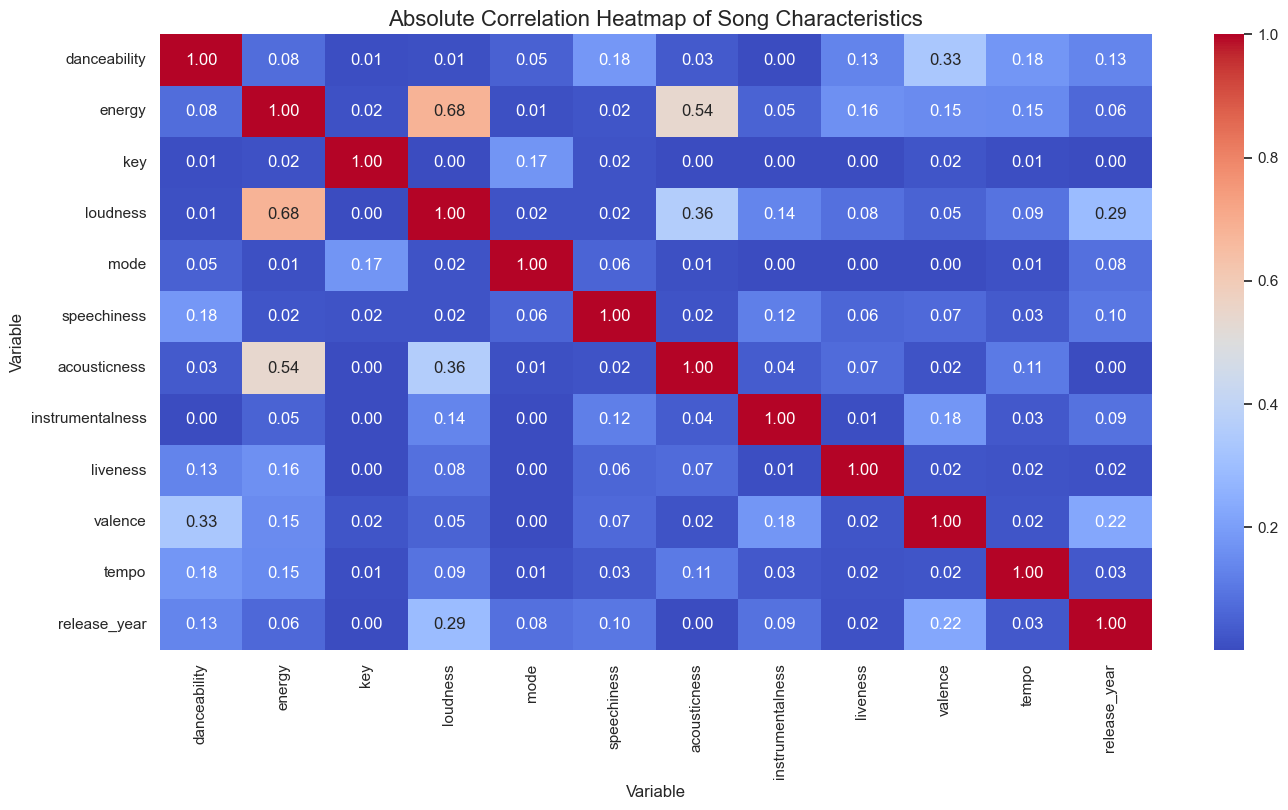

In [139]:
ax = sns.heatmap(abs(clustering_data.corr()),annot=True,fmt="0.2f",cmap="coolwarm")
sns.set_theme(rc={'figure.figsize':(16,8)})

plt.title('Absolute Correlation Heatmap of Song Characteristics')
plt.xlabel('Variable')
plt.ylabel('Variable')
ax.title.set_size(16)

plt.show()

%matplotlib inline

For that reason, PCA will be evaluated as an alternative to:
* Reduce complexity by reducing dimensionality
* Mitigate possible multicollinearity issues
* Mitigate the impact of noise (noise over signal issue)
* Possibly improve clustering performance

Explained Variance Ratio for 1 components: [0.83423616]
Total Variance Captured by 1 Components: 83.42%

Explained Variance Ratio for 2 components: [0.83423616 0.14075334]
Total Variance Captured by 2 Components: 97.50%

Explained Variance Ratio for 3 components: [0.83423616 0.14075334 0.01514406]
Total Variance Captured by 3 Components: 99.01%

Explained Variance Ratio for 4 components: [0.83423616 0.14075334 0.01514406 0.00934057]
Total Variance Captured by 4 Components: 99.95%

Explained Variance Ratio for 5 components: [8.34236158e-01 1.40753335e-01 1.51440592e-02 9.34056725e-03
 2.74408610e-04]
Total Variance Captured by 5 Components: 99.97%

Explained Variance Ratio for 6 components: [8.34236158e-01 1.40753335e-01 1.51440592e-02 9.34056725e-03
 2.74408610e-04 7.27758325e-05]
Total Variance Captured by 6 Components: 99.98%

Explained Variance Ratio for 7 components: [8.34236158e-01 1.40753335e-01 1.51440592e-02 9.34056725e-03
 2.74408610e-04 7.27758325e-05 6.00988081e-05]
Total Va

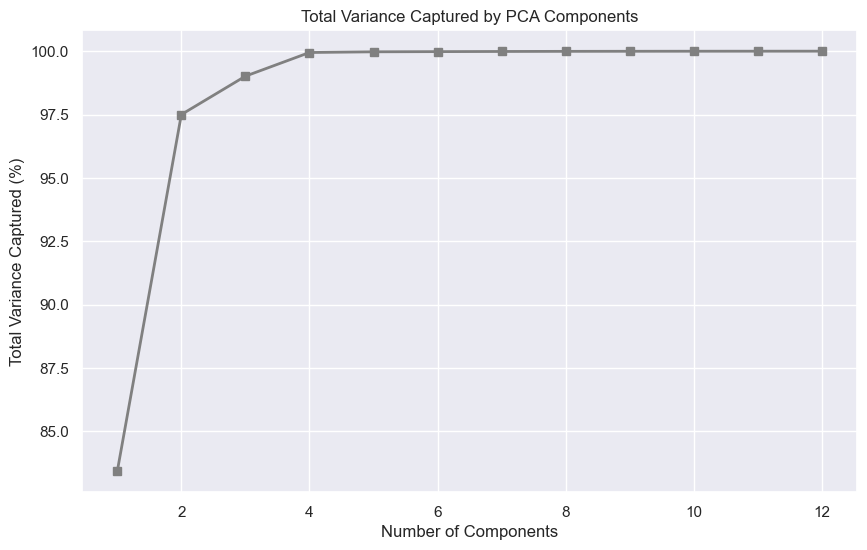

In [140]:
comps = range(1, clustering_data.shape[1] + 1)




variance_captured = []

for comp in comps:
    pca = PCA(n_components=comp)
    pca.fit(clustering_data)
    total_variance_captured = pca.explained_variance_ratio_.sum() * 100
    variance_captured.append(total_variance_captured)

    print(f"Explained Variance Ratio for {comp} components: {pca.explained_variance_ratio_}")
    print(f"Total Variance Captured by {comp} Components: {total_variance_captured:.2f}%\n")


plt.figure(figsize=(10, 6))
plt.plot(comps, variance_captured, marker='s', color='gray', linestyle='-', linewidth=2, markersize=6)
plt.title('Total Variance Captured by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Total Variance Captured (%)')
plt.show()

Given the marginal expplained variance gains when adding more components, 2 components will be the quantity of PCA components chosen to carry forward into the study. 97.5% of the variance is explained with 2 components, which indicates that there might be redundant features in the dataset (i.e.: offer the same information or are correlated) and the data structe is conducive to dimensionality reduction. Using PCA is also expected to help the clustering algorithms focus in the components that are truly driving variance, instead of shifting focus towards noise, correlated features, or irrelevant features that bring no informational value to the clusters.
In addition to that, applying PCA goes hand-in-hand with the proposed complexity reduction in recommendation algorithms, a pillar of the philosophy supporting this study.

In [141]:
pca = PCA(n_components=2)

raw_data = clustering_data
pca_data = pca.fit_transform(raw_data)

### Agglomerative Clustering

In [142]:
performance_df = pd.DataFrame()

n_clusters_range = range(2, 20,2)

for n_clusters in n_clusters_range:
    aggl_raw = AgglomerativeClustering(n_clusters=n_clusters)
    raw_labels = aggl_raw.fit_predict(raw_data)

    aggl_pca = AgglomerativeClustering(n_clusters=n_clusters)
    pca_labels = aggl_pca.fit_predict(pca_data)

    raw_davies_bouldin = round(davies_bouldin_score(raw_data, raw_labels), 2)
    raw_calinski_harabasz = round(calinski_harabasz_score(raw_data, raw_labels), 0)
    raw_silhouette_avg = round(silhouette_score(raw_data, raw_labels), 2)

    pca_davies_bouldin = round(davies_bouldin_score(pca_data, pca_labels), 2)
    pca_calinski_harabasz = round(calinski_harabasz_score(pca_data, pca_labels), 0)
    pca_silhouette_avg = round(silhouette_score(pca_data, pca_labels), 2)

    new_row = pd.DataFrame({
        "n_clusters": n_clusters,
        "Raw_Davies_Bouldin": raw_davies_bouldin,
        "PCA_Davies_Bouldin": pca_davies_bouldin,
        "Raw_Calinski_Harabasz": raw_calinski_harabasz,
        "PCA_Calinski_Harabasz": pca_calinski_harabasz,
        "Raw_Silhouette_Score": raw_silhouette_avg,
        "PCA_Silhouette_Score": pca_silhouette_avg
    }, index=[f"Agglomerative Clusters with {n_clusters} clusters"])

    performance_df = pd.concat([new_row, performance_df])


In [143]:
performance_df

,n_clusters,Raw_Davies_Bouldin,PCA_Davies_Bouldin,Raw_Calinski_Harabasz,PCA_Calinski_Harabasz,Raw_Silhouette_Score,PCA_Silhouette_Score
Agglomerative Clusters with 18 clusters,18,1.08,0.84,18417.0,28732.0,0.24,0.37
Agglomerative Clusters with 16 clusters,16,1.10,0.89,18645.0,28491.0,0.22,0.37
Agglomerative Clusters with 14 clusters,14,1.08,0.89,19197.0,28313.0,0.26,0.35
Agglomerative Clusters with 12 clusters,12,1.01,0.89,20158.0,28129.0,0.27,0.39
Agglomerative Clusters with 10 clusters,10,1.04,0.86,21923.0,28990.0,0.32,0.41
Agglomerative Clusters with 8 clusters,8,0.97,0.81,24522.0,30062.0,0.37,0.42
Agglomerative Clusters with 6 clusters,6,0.92,0.82,24787.0,29351.0,0.35,0.40
Agglomerative Clusters with 4 clusters,4,0.82,0.78,25317.0,31393.0,0.46,0.51
Agglomerative Clusters with 2 clusters,2,0.80,0.76,22140.0,22937.0,0.42,0.44


### Gaussian Mixture

In [144]:
n_clusters_range = range(2, 20,2)

for n_clusters in n_clusters_range:

    gmm_raw = GaussianMixture(n_components=n_clusters)
    raw_labels = gmm_raw.fit_predict(raw_data)


    gmm_pca = GaussianMixture(n_components=n_clusters)
    pca_labels = gmm_pca.fit_predict(pca_data)

    raw_davies_bouldin = round(davies_bouldin_score(raw_data, raw_labels), 2)
    raw_calinski_harabasz = round(calinski_harabasz_score(raw_data, raw_labels), 0)
    raw_silhouette_avg = round(silhouette_score(raw_data, raw_labels), 2)


    pca_davies_bouldin = round(davies_bouldin_score(pca_data, pca_labels), 2)
    pca_calinski_harabasz = round(calinski_harabasz_score(pca_data, pca_labels), 0)
    pca_silhouette_avg = round(silhouette_score(pca_data, pca_labels), 2)

    new_row = pd.DataFrame({
        "n_clusters": n_clusters,
        "Raw_Davies_Bouldin": raw_davies_bouldin,
        "PCA_Davies_Bouldin": pca_davies_bouldin,
        "Raw_Calinski_Harabasz": raw_calinski_harabasz,
        "PCA_Calinski_Harabasz": pca_calinski_harabasz,
        "Raw_Silhouette_Score": raw_silhouette_avg,
        "PCA_Silhouette_Score": pca_silhouette_avg
    }, index=[f"Gaussian Mixture Clusters with {n_clusters} clusters"])

    performance_df = pd.concat([new_row, performance_df])


In [145]:
performance_df

,n_clusters,Raw_Davies_Bouldin,PCA_Davies_Bouldin,Raw_Calinski_Harabasz,PCA_Calinski_Harabasz,Raw_Silhouette_Score,PCA_Silhouette_Score
Gaussian Mixture Clusters with 18 clusters,18,18.87,2.78,352.0,4811.0,-0.36,-0.02
Gaussian Mixture Clusters with 16 clusters,16,10.53,3.21,452.0,3861.0,-0.28,-0.12
Gaussian Mixture Clusters with 14 clusters,14,11.79,3.50,513.0,4580.0,-0.30,-0.07
Gaussian Mixture Clusters with 12 clusters,12,10.84,3.04,547.0,3933.0,-0.28,-0.10
Gaussian Mixture Clusters with 10 clusters,10,11.18,2.61,277.0,4557.0,-0.24,-0.06
Gaussian Mixture Clusters with 8 clusters,8,12.82,10.98,288.0,3025.0,-0.22,-0.13
Gaussian Mixture Clusters with 6 clusters,6,7.85,2.01,306.0,8538.0,-0.21,0.04
Gaussian Mixture Clusters with 4 clusters,4,17.29,5.55,275.0,2328.0,-0.15,-0.01
Gaussian Mixture Clusters with 2 clusters,2,17.92,2.59,40.0,2487.0,-0.03,0.18
Agglomerative Clusters with 18 clusters,18,1.08,0.84,18417.0,28732.0,0.24,0.37


### KMeans Clustering

In [146]:
n_clusters_range = range(2, 20,2)

for n_clusters in n_clusters_range:
    knn_raw = KMeans(n_clusters=n_clusters)
    raw_labels = knn_raw.fit_predict(raw_data)


    knn_pca = KMeans(n_clusters=n_clusters)
    pca_labels = knn_pca.fit_predict(pca_data)

    raw_davies_bouldin = round(davies_bouldin_score(raw_data, raw_labels), 2)
    raw_calinski_harabasz = round(calinski_harabasz_score(raw_data, raw_labels), 0)
    raw_silhouette_avg = round(silhouette_score(raw_data, raw_labels), 2)

    pca_davies_bouldin = round(davies_bouldin_score(pca_data, pca_labels), 2)
    pca_calinski_harabasz = round(calinski_harabasz_score(pca_data, pca_labels), 0)
    pca_silhouette_avg = round(silhouette_score(pca_data, pca_labels), 2)

    new_row = pd.DataFrame({
        "n_clusters": n_clusters,
        "Raw_Davies_Bouldin": raw_davies_bouldin,
        "PCA_Davies_Bouldin": pca_davies_bouldin,
        "Raw_Calinski_Harabasz": raw_calinski_harabasz,
        "PCA_Calinski_Harabasz": pca_calinski_harabasz,
        "Raw_Silhouette_Score": raw_silhouette_avg,
        "PCA_Silhouette_Score": pca_silhouette_avg
    }, index=[f"KMeans Clusters with {n_clusters} clusters"])

    performance_df = pd.concat([new_row, performance_df])


### Clustering Conclusion

The comparative performance metrics suggests that the PCA reduced clustering process resulted in better performance. For that reason, the PCA reduced clustering processes will be evaluated, so that the best performing combination is elected to move forward in the study.

In [147]:
performance_df

,n_clusters,Raw_Davies_Bouldin,PCA_Davies_Bouldin,Raw_Calinski_Harabasz,PCA_Calinski_Harabasz,Raw_Silhouette_Score,PCA_Silhouette_Score
KMeans Clusters with 18 clusters,18,1.03,0.81,21155.0,33913.0,0.28,0.38
KMeans Clusters with 16 clusters,16,1.02,0.78,22410.0,34985.0,0.27,0.41
KMeans Clusters with 14 clusters,14,0.99,0.78,22106.0,34414.0,0.34,0.44
KMeans Clusters with 12 clusters,12,1.02,0.82,23893.0,33814.0,0.29,0.42
KMeans Clusters with 10 clusters,10,0.98,0.82,25492.0,33712.0,0.33,0.42
KMeans Clusters with 8 clusters,8,0.87,0.76,27347.0,34550.0,0.39,0.46
KMeans Clusters with 6 clusters,6,0.97,0.72,25151.0,31721.0,0.39,0.44
KMeans Clusters with 4 clusters,4,0.76,0.70,30716.0,34652.0,0.48,0.52
KMeans Clusters with 2 clusters,2,0.81,0.79,25533.0,26855.0,0.45,0.47
Gaussian Mixture Clusters with 18 clusters,18,18.87,2.78,352.0,4811.0,-0.36,-0.02


### Best Model

**Calinski-Harabasz**

In [777]:
performance_df[['n_clusters', 'PCA_Davies_Bouldin',
       'PCA_Calinski_Harabasz',
       'PCA_Silhouette_Score']].nlargest(5, columns='PCA_Calinski_Harabasz')

,n_clusters,PCA_Davies_Bouldin,PCA_Calinski_Harabasz,PCA_Silhouette_Score
KMeans Clusters with 16 clusters,16,0.78,34985.0,0.41
KMeans Clusters with 4 clusters,4,0.70,34652.0,0.52
KMeans Clusters with 8 clusters,8,0.76,34550.0,0.46
KMeans Clusters with 14 clusters,14,0.78,34414.0,0.44
KMeans Clusters with 18 clusters,18,0.81,33913.0,0.38


**Davies-Bouldin**

In [778]:
performance_df[['n_clusters', 'PCA_Davies_Bouldin',
       'PCA_Calinski_Harabasz',
       'PCA_Silhouette_Score']].nsmallest(5, columns='PCA_Davies_Bouldin')

,n_clusters,PCA_Davies_Bouldin,PCA_Calinski_Harabasz,PCA_Silhouette_Score
KMeans Clusters with 4 clusters,4,0.70,34652.0,0.52
KMeans Clusters with 6 clusters,6,0.72,31721.0,0.44
KMeans Clusters with 8 clusters,8,0.76,34550.0,0.46
Agglomerative Clusters with 2 clusters,2,0.76,22937.0,0.44
KMeans Clusters with 16 clusters,16,0.78,34985.0,0.41


**Silhouette Score**

In [779]:
performance_df[['n_clusters', 'PCA_Davies_Bouldin',
       'PCA_Calinski_Harabasz',
       'PCA_Silhouette_Score']].nlargest(5, columns='PCA_Silhouette_Score')

,n_clusters,PCA_Davies_Bouldin,PCA_Calinski_Harabasz,PCA_Silhouette_Score
KMeans Clusters with 4 clusters,4,0.70,34652.0,0.52
Agglomerative Clusters with 4 clusters,4,0.78,31393.0,0.51
KMeans Clusters with 2 clusters,2,0.79,26855.0,0.47
KMeans Clusters with 8 clusters,8,0.76,34550.0,0.46
KMeans Clusters with 14 clusters,14,0.78,34414.0,0.44


The *PCA Reduced KMeans Clusters with 4 clusters* is the clustering algorithm of choice given that:
* It presents the 2nd best Calinski-Harabasz score, indicating that it has the 2nd most distinct and well-separated clusters of all algorithms studied.
* It presents the best Davies-Bouldin score, indicating that its clusters show less dispersion and are less similar in comparison to other algorithms.
* It presents the the best Silhouette Score, which means that its samples are closer to their assigned cluster than to other clusters.

Observations:

Standard Scaling was attempted and significantly hurt the performance of clustering algorithms. For that reason, PCA alone was deemed a better alternative.

In [922]:
k_cluster = KMeans(n_clusters=4, random_state=42)
songs.loc[:, 'kmeans_labels'] = k_cluster.fit_predict(pca_data)

Ensuring that clusters have enough members (at least 21 or 20 recommendations):

In [830]:
songs.kmeans_labels.value_counts()

kmeans_labels
0    11222
1     8530
2     4024
3     2190
Name: count, dtype: int64

In [831]:
songs.select_dtypes(include='number').describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_year,track_artist_label,track_album_id_label,kmeans_labels
count,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000,25966.000000
mean,39.531965,0.653651,0.698998,5.375144,-6.792184,0.564122,0.108309,0.177775,0.091366,0.191336,0.506307,121.113266,226910.044443,2011.452938,5273.946353,10510.152315,0.891473
std,23.292275,0.145356,0.182314,3.613232,2.984698,0.495881,0.102863,0.222644,0.232229,0.156709,0.234459,26.820973,59918.297314,10.987804,3075.115002,6081.395953,0.955392
min,0.000000,0.077100,0.000175,0.000000,-46.448000,0.000000,0.022400,0.000001,0.000000,0.009360,0.000010,37.114000,107383.000000,1957.000000,0.000000,0.000000,0.000000
25%,23.000000,0.562000,0.580000,2.000000,-8.282000,0.000000,0.041000,0.014200,0.000000,0.092800,0.325000,99.990000,187547.000000,2009.000000,2579.250000,5253.250000,0.000000
50%,42.000000,0.670000,0.722000,6.000000,-6.249000,1.000000,0.062800,0.080200,0.000021,0.127000,0.507000,122.024500,216321.000000,2016.000000,5240.000000,10481.500000,1.000000
75%,58.000000,0.760000,0.843000,9.000000,-4.712000,1.000000,0.134000,0.262000,0.006808,0.248000,0.690000,134.033750,254319.500000,2019.000000,7911.000000,15723.750000,1.000000
max,98.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.992000,0.994000,0.996000,0.991000,239.440000,517810.000000,2020.000000,10610.000000,21064.000000,3.000000


### General Clusters Characteristics

*Clusters and Year Released*

* **Cluster 0**: Composed of newer songs, mostly released between 2010 and 2020.
* **Cluster 1**: Composed of songs mostly released between 2000 and 2010, with some instances between 2010 and 2020 and sporadic instances before the 1990s.
* **Cluster 2**: Fairly evenly distribution accross decades.
* **Cluster 3**: Composed of older songs (before the 1990s), with few instances in the 2000s.

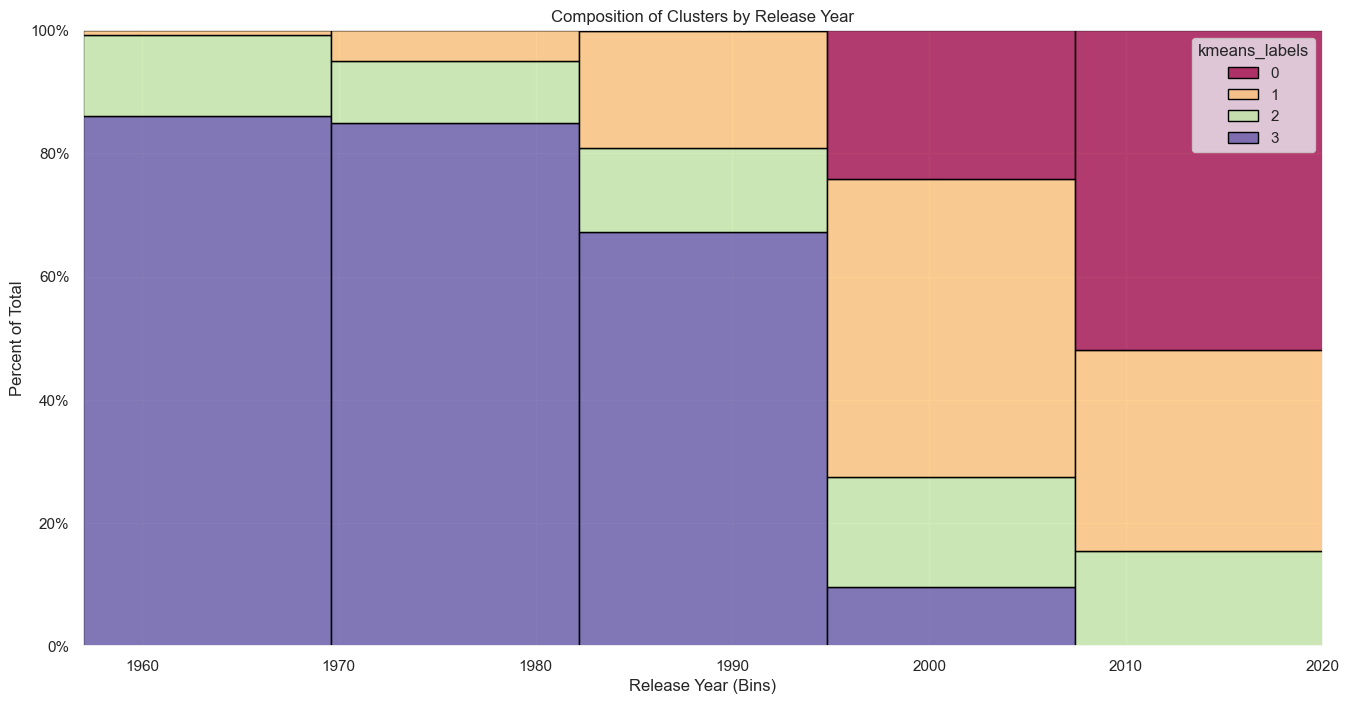

In [832]:
ax=sns.histplot(data=songs,x='release_year',hue='kmeans_labels',bins=5,edgecolor='black',palette='Spectral',multiple='fill',)

plt.xlabel('Release Year (Bins)')
plt.ylabel('Percent of Total')
plt.title('Composition of Clusters by Release Year')
ax.yaxis.set_major_formatter(tk.StrMethodFormatter('{x:,.0%}'))
plt.show()
%matplotlib inline

*Clusters and Tempo and Energy*

* **Cluster 0**: Composed of of songs with moderate tempo (i.e.: not too fast or too slow) with high energy.
* **Cluster 1**: Composed of of songs with slow tempo, likely mellow in style, which can be seen by the lowest levels of energy.
* **Cluster 2**: Fastest songs, tending to be moderately to high energy like Folk-pop or Indie Folk music, for example.
* **Cluster 3**: Composed of songs with moderate tempos, although more sparse in comparison to cluster 0, which clusters ~125 BPM. More uniformly distributed for energy levels, demonstrating more diversity.

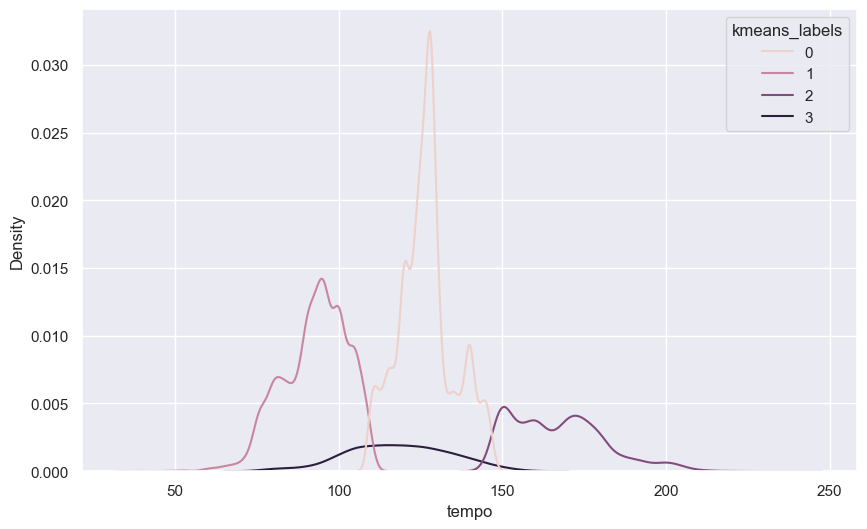

In [833]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(data=songs, x='tempo', hue='kmeans_labels')
plt.show()
%matplotlib inline

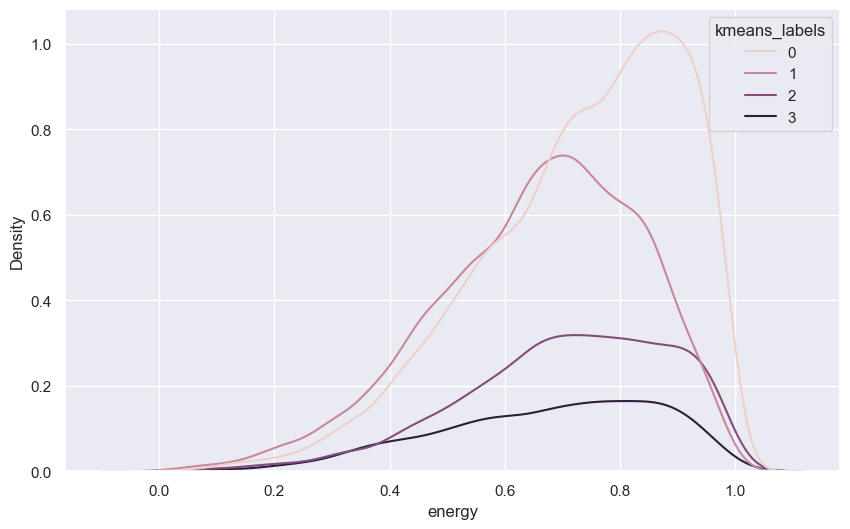

In [834]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(data=songs, x='energy', hue='kmeans_labels')
plt.show()
%matplotlib inline

*Clusters and Tempo and Energy*

* **Cluster 0**: Composed of of songs with mostly low mood (e.g.: sad, depressed, angry) themes.
* **Cluster 1**: Composed of songs that are mostly neutral in mood and theme.
* **Cluster 2**: Composed of thematically diverse songs, with some tendency for neutrality, though more diverse than cluster 1.
* **Cluster 3**: Composed of songs tending to be thematically upbeat (e.g.: happy, cheerful) in comparison to the remmaining clusters, represented by a slight left skew.

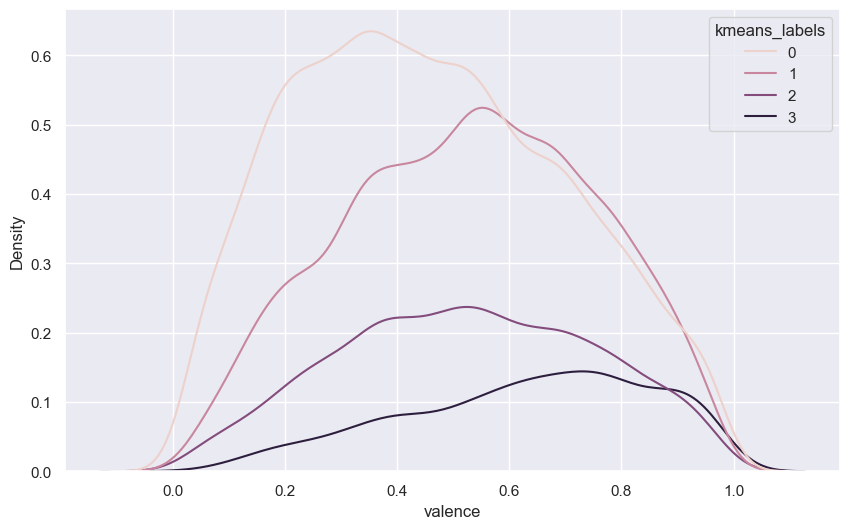

In [835]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(data=songs, x='valence', hue='kmeans_labels')
plt.show()
%matplotlib inline

#  Similarity Metrics

The similarity of the songs will be evaluated based on characteristics that audibly differentiates one song from the next.

For that reason, the **release_year** will not be used to compare similarity metrics since it does not represent a characteristic describing what the song sounds like. Rather it offers context to the algorithm (e.g.: pop from the 1980s vs pop from the 2000s), which has been successfully captured by the clusters. Likewise, the **duration_ms**  will not be used to compare the songs either, as that solely describes the length of the track and does not describe any audible characteristic.


In [923]:
clustering_data =  songs[['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence','tempo']].copy()


## User input

In [924]:
songs['artist_track'] = songs.apply(lambda x: f"{x['track_artist']} - {x['track_name']}", axis=1)

Please input the song to receive recommendations of like songs:

In [925]:
song_name = "Ozzy Osbourne - Crazy Train"
top_n= 10

In [926]:
user_input = songs[(songs.artist_track==song_name)]

user_input.index

Index([11065], dtype='int64')

In [927]:
clustering_data.loc[:, 'kmeans_labels'] = songs['kmeans_labels']
num_user_input = clustering_data.loc[user_input.index]

num_user_input

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,kmeans_labels
11065,0.453,0.906,9,-4.001,1,0.115,0.361,0.000569,0.26,0.473,137.575,3


In [928]:
like_songs = clustering_data[(clustering_data.kmeans_labels.values==num_user_input.kmeans_labels.values)]

like_songs = like_songs.drop(index=user_input.index)

In [929]:
like_songs.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'kmeans_labels'],
      dtype='object')

In [930]:
num_user_input.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'kmeans_labels'],
      dtype='object')

## Cosine Similarity

[Documentation](https://scikit-learn.org/dev/modules/metrics.html#cosine-similarity)

Cosine similarity measures the cosine of the angle between two non-zero vectors in a multi-dimensional space. It evaluates how aligned two vectors are, irrespective of their magnitude. 

[Source, page 77](https://ia800702.us.archive.org/7/items/datamining_201811/DS-book%20u5.pdf)

The cosine similarity focuses only on the direction of vectors, which would ensure that the songs with similar characteristics are "pointing" to the same direction. In other words, it captures similarity in the "shape" of data points without being affected by their scale. At the same time, magnitude may be important when defining song characteristics, which means that it may not perform optimally in this use case. Also, it assumes linear relationships, which may not be accurate for this application.

### With Clustering

In [931]:
cosine_sim = pd.Series(cosine_similarity(num_user_input, like_songs).flatten())

similar = cosine_sim.nlargest(top_n)

recommended_tracks = songs[songs.index.isin(similar.index)]

In [932]:
display(recommended_tracks[['track_name','track_artist','track_album_name']])

,track_name,track_artist,track_album_name
128,Spicy (with Diplo & Charli XCX),Herve Pagez,Spicy (with Diplo & Charli XCX)
381,光線,Ghost like girlfriend,光線
548,"My One (feat. Tory Lanez, Kranium & Dappy) (To...",Wiley,My One (Todd Edwards Remix)
713,Bésame,David Bisbal,Bésame
849,Paradise,Matthew Parker,Daydreamer
866,Grateful (Neon Feather Remix),Cade Thompson,Grateful (Neon Feather Remix)
992,Nothin' to Compare,Who,Nothin' to Compare
1320,What Am I,Why Don't We,What Am I
1512,It's Time,Imagine Dragons,Night Visions
1569,Poppin' Champagne,All Time Low,"So Wrong, It's Right (Deluxe Version)"


### No Clustering

In [933]:
cosine_sim = pd.Series(cosine_similarity(num_user_input, clustering_data).flatten())

similar = cosine_sim.nlargest(top_n)

recommended_tracks = songs[songs.index.isin(similar.index)]

In [934]:
display(recommended_tracks[['track_name','track_artist','track_album_name']])

,track_name,track_artist,track_album_name
2989,Big in Japan - Best of-Version,Alphaville,First Harvest 1984-1992
9940,Y Ahora,Nengo Flow,Y Ahora
10669,Uprising,Muse,The Resistance
10875,Cool Cat - Remastered 2011,Queen,Hot Space (2011 Remaster)
10889,Hombre Al Agua - Remasterizado 2007,Soda Stereo,El Ultimo Concierto A
10919,Barracuda,Heart,Little Queen
11294,Lost In Love,Air Supply,Lost in Love
12172,Walkin' On The Sun,Smash Mouth,Fush Yu Mang (20th Anniversary Edition)
13161,Summer Of '69,Bryan Adams,Anthology (set - UK)
14683,4 Life (feat. Graham Candy),Robin Schulz,Sugar


## Mahalanobis Distance for Similarity

[Source](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html)

Mahalanobis distance measures the distance between a point and a distribution, considering correlations between features. Because the distance is in relation to distributions, correlations are accounted for in the covariance matrix and is independent of scales. These two characteristics are especially good for a dataset in which so few PCA components (2) can eplain so much of the variance, as this may indicate close correlation between variables.

The Mahalanobis distance requires the inverse of the covariance matrix, which may not be inversible because, among other factors, the dataset has linearly dependent features or if the number of features exceeds the number of observations and is the case in this application. For that reason, the pseudoinverse (Moore-Penrose inverse) will be used instead of the inverse, as it is often used in linear algebra problems where the standard inverse cannot be applied. This approach may introduce small inaccuracies in the process when compared to the true inverse, if it is existent.

[Source](https://medium.com/accredian/moore-penrose-inverse-simplified-3e0a6cd2965e)

<font color="blue">ChatGPT</font> used in resolving the inverse of the covariance matrix issue.

### With Clustering

In [935]:
cov_matrix = np.cov(like_songs, rowvar=False)

try:

    inv_cov_matrix = np.linalg.inv(cov_matrix)
except LinAlgError:
    # If the covariance matrix is singular, compute the pseudoinverse
    inv_cov_matrix = np.linalg.pinv(cov_matrix)

def find_top_similar_songs(songs_df, user_song, inv_cov_matrix, top_n=top_n):
    user_song = np.array(user_song.values.flatten())
    
    distances = {}
    for idx, song_features in songs_df.iterrows():
        song_features = np.array(song_features.values.flatten())
        distances[idx] = distance.mahalanobis(user_song, song_features, inv_cov_matrix)
    
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    top_similar_indices = [idx for idx, _ in sorted_distances[:top_n]]
    
    top_songs = songs_df.loc[top_similar_indices]
    top_distances = [distances[idx] for idx in top_similar_indices]
    
    return top_songs, top_distances

top_songs, top_distances = find_top_similar_songs(like_songs, num_user_input, inv_cov_matrix, top_n=top_n)
print("Top  Similar Songs:")
for idx, (song, dist) in enumerate(zip(top_songs.iterrows(), top_distances), 1):
    print(f"{idx}. Song:\n{song[1]}\nSimilarity Score (Mahalanobis Distance): {dist}\n")

Top  Similar Songs:
1. Song:
danceability          0.563000
energy                0.915000
key                   7.000000
loudness             -5.062000
mode                  1.000000
speechiness           0.080000
acousticness          0.247000
instrumentalness      0.000085
liveness              0.061300
valence               0.710000
tempo               136.345000
kmeans_labels         3.000000
Name: 10512, dtype: float64
Similarity Score (Mahalanobis Distance): 1.8781881457259024

2. Song:
danceability          0.497000
energy                0.947000
key                   7.000000
loudness             -2.120000
mode                  1.000000
speechiness           0.109000
acousticness          0.025800
instrumentalness      0.000013
liveness              0.332000
valence               0.517000
tempo               134.589000
kmeans_labels         3.000000
Name: 13122, dtype: float64
Similarity Score (Mahalanobis Distance): 2.083686910887194

3. Song:
danceability          0.4610
ene

In [936]:

recommended_tracks = songs[(songs.index.isin(top_songs.index))][['track_name','track_artist','track_album_name']]


display(recommended_tracks)

,track_name,track_artist,track_album_name
10034,Hair Of The Dog,Guns N' Roses,The Spaghetti Incident?
10512,All Day and All of the Night,The Kinks,Kinks (Deluxe Edition)
10612,Tonight's the Night (Gonna Be Alright),Rod Stewart,A Night on the Town
10780,Keep Yourself Alive - 2011 Mix,Queen,Queen (2011 Remaster)
10859,Need Your Loving Tonight - Remastered 2011,Queen,The Game (2011 Remaster)
11485,Dance The Night Away,Van Halen,Van Halen II
11878,Panama - 2015 Remaster,Van Halen,1984 (Remastered)
12555,Stay Free - Remastered,The Clash,Give 'Em Enough Rope (Remastered)
13122,Bad Boys Running Wild,Scorpions,Love At First Sting (50th Anniversary Deluxe E...
13686,Seek & Destroy,Metallica,Kill 'Em All


### No Clustering

In [937]:
cov_matrix = np.cov(clustering_data.drop(index=user_input.index), rowvar=False)

try:
    inv_cov_matrix = np.linalg.inv(cov_matrix)
except LinAlgError:
    inv_cov_matrix = np.linalg.pinv(cov_matrix)


def find_top_similar_songs(songs_df, user_song, inv_cov_matrix, top_n=top_n):
    user_song = np.array(user_song.values.flatten())
    

    distances = {}
    for idx, song_features in songs_df.iterrows():
        song_features = np.array(song_features.values.flatten())
        distances[idx] = distance.mahalanobis(user_song, song_features, inv_cov_matrix)
    
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    top_similar_indices = [idx for idx, _ in sorted_distances[:top_n]]
    

    top_songs = songs_df.loc[top_similar_indices]
    top_distances = [distances[idx] for idx in top_similar_indices]
    
    return top_songs, top_distances


top_songs, top_distances = find_top_similar_songs(clustering_data.drop(index=user_input.index), num_user_input, inv_cov_matrix, top_n=top_n)
print("Top  Similar Songs:")
for idx, (song, dist) in enumerate(zip(top_songs.iterrows(), top_distances), 1):
    print(f"{idx}. Song:\n{song[1]}\nSimilarity Score (Mahalanobis Distance): {dist}\n")

Top  Similar Songs:
1. Song:
danceability          0.55100
energy                0.84000
key                   7.00000
loudness             -3.47400
mode                  1.00000
speechiness           0.13500
acousticness          0.19700
instrumentalness      0.00001
liveness              0.28600
valence               0.47800
tempo               147.01400
kmeans_labels         2.00000
Name: 7894, dtype: float64
Similarity Score (Mahalanobis Distance): 1.9074324687838526

2. Song:
danceability          0.6040
energy                0.8760
key                   9.0000
loudness             -3.8790
mode                  1.0000
speechiness           0.0393
acousticness          0.3260
instrumentalness      0.0000
liveness              0.2420
valence               0.8040
tempo               137.8210
kmeans_labels         3.0000
Name: 10859, dtype: float64
Similarity Score (Mahalanobis Distance): 1.9163201560697

3. Song:
danceability          0.49700
energy                0.91400
key        

In [938]:
recommended_tracks = songs[(songs.index.isin(top_songs.index))][['track_name','track_artist','track_album_name']]

display(recommended_tracks)

,track_name,track_artist,track_album_name
4300,Pleaser,Wallows,Pleaser
7894,Echo,Bad Meets Evil,Hell: The Sequel (Deluxe)
10512,All Day and All of the Night,The Kinks,Kinks (Deluxe Edition)
10525,Killer Queen - Remastered 2011,Queen,Sheer Heart Attack (2011 Remaster)
10801,Killer Queen - 2011 Mix,Queen,Sheer Heart Attack (2011 Remaster)
10839,"Get Down, Make Love - Remastered 2011",Queen,News Of The World (2011 Remaster)
10859,Need Your Loving Tonight - Remastered 2011,Queen,The Game (2011 Remaster)
12158,If You're Gone,Matchbox Twenty,Mad Season
13122,Bad Boys Running Wild,Scorpions,Love At First Sting (50th Anniversary Deluxe E...
13686,Seek & Destroy,Metallica,Kill 'Em All


## Bray-Curtis Dissimilarity Score

[Source](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.braycurtis.html)

The Bray-Curtis dissimilarity is a metric used to quantify the compositional difference between two samples based on their feature abundances, rangind from 0 (identical) to 1 (completely dissimilar). This measure would normalize by the sum of features, making it robust to differences in total counts or, in this case, magnitudes. Because this metric deals with abundance and composition, negative values are not well tolerated by the Bray_Curtis dissimilarity metric;; for that reason, the MinMaxScaler will be applied to the **loudness** feaature to limit it from 0 to 1, thus eliminating negative values. Unlike the Mahalanobis metric it cannot account for reltioships between features.

[Source](https://uw.pressbooks.pub/appliedmultivariatestatistics/chapter/common-distance-measures/)

In [939]:
scaler = MinMaxScaler()

like_songs['loudness_scaled'] = scaler.fit_transform(like_songs[['loudness']])
like_songs=like_songs.drop(columns='loudness')

clustering_data['loudness_scaled'] = scaler.fit_transform(clustering_data[['loudness']])
clustering_data=clustering_data.drop(columns='loudness')

### With Clustering

In [940]:
def find_top_similar_songs_bray_curtis(songs_df, user_song, top_n):
    user_song = np.array(user_song.values.flatten())
    
    distances = {}
    
    for idx, song_features in songs_df.iterrows():
        song_features = np.array(song_features.values.flatten())
        distances[idx] = braycurtis(user_song, song_features)
    

    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    top_similar_indices = [idx for idx, _ in sorted_distances[:top_n]]
    

    top_songs = songs_df.loc[top_similar_indices]
    top_distances = [distances[idx] for idx in top_similar_indices]
    
    return top_songs, top_distances

top_songs_bray, top_distances_bray = find_top_similar_songs_bray_curtis(like_songs, num_user_input, top_n=top_n)


print("Top Similar Songs (Bray-Curtis Dissimilarity):")
for idx, (song, dist) in enumerate(zip(top_songs_bray.iterrows(), top_distances_bray), 1):
    print(f"{idx}. Song:\n{song[1]}\nDissimilarity Score (Bray-Curtis): {dist}\n")


Top Similar Songs (Bray-Curtis Dissimilarity):
1. Song:
danceability         0.56600
energy               0.76500
key                 10.00000
mode                 0.00000
speechiness          0.03230
acousticness         0.18000
instrumentalness     0.01330
liveness             0.13600
valence              0.96900
tempo               75.00800
kmeans_labels        3.00000
loudness_scaled      0.63694
Name: 11354, dtype: float64
Dissimilarity Score (Bray-Curtis): 0.8812715417672328

2. Song:
danceability         0.320000
energy               0.798000
key                 10.000000
mode                 0.000000
speechiness          0.124000
acousticness         0.000330
instrumentalness     0.692000
liveness             0.176000
valence              0.740000
tempo               84.696000
kmeans_labels        3.000000
loudness_scaled      0.656397
Name: 12231, dtype: float64
Dissimilarity Score (Bray-Curtis): 0.8839291465155545

3. Song:
danceability         0.662000
energy               0

In [941]:
recommended_tracks = songs[(songs.index.isin(top_songs_bray.index))][['track_name','track_artist','track_album_name']]


display(recommended_tracks)

,track_name,track_artist,track_album_name
10026,Right Next Door To Hell,Guns N' Roses,Use Your Illusion I
10162,最後のナイト・フライト,オメガトライブ,River's Island
10941,The Temple Of The King,Rainbow,Ritchie Blackmore's Rainbow
11354,Good Golly Miss Molly,Creedence Clearwater Revival,Bayou Country (40th Anniversary Edition)
11599,Heaven,Ebo Taylor,Life Stories
11622,Stairway to Heaven - Remaster,Led Zeppelin,Led Zeppelin IV (Deluxe Edition)
11709,Holy Diver,Dio,Holy Diver
12231,Disorder - 2007 Remaster,Joy Division,Unknown Pleasures
13628,Billion Dollar Babies,Alice Cooper,Alice Cooper's Greatest Hits
18686,Hard Times,Baby Huey & The Baby Sitters,The Baby Huey Story: The Living Legend


### No Clustering

In [942]:
def find_top_similar_songs_bray_curtis(songs_df, user_song, top_n):
    user_song = np.array(user_song.values.flatten())
    
    distances = {}
    
    for idx, song_features in songs_df.iterrows():
        song_features = np.array(song_features.values.flatten())
        distances[idx] = braycurtis(user_song, song_features)
    
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    top_similar_indices = [idx for idx, _ in sorted_distances[:top_n]]
    
    top_songs = songs_df.loc[top_similar_indices]
    top_distances = [distances[idx] for idx in top_similar_indices]
    
    return top_songs, top_distances


top_songs_bray, top_distances_bray = find_top_similar_songs_bray_curtis(clustering_data, num_user_input, top_n=top_n)

print("Top Similar Songs (Bray-Curtis Dissimilarity):")
for idx, (song, dist) in enumerate(zip(top_songs_bray.iterrows(), top_distances_bray), 1):
    print(f"{idx}. Song:\n{song[1]}\nDissimilarity Score (Bray-Curtis): {dist}\n")


Top Similar Songs (Bray-Curtis Dissimilarity):
1. Song:
danceability         0.566000
energy               0.765000
key                 10.000000
mode                 0.000000
speechiness          0.032300
acousticness         0.180000
instrumentalness     0.013300
liveness             0.136000
valence              0.969000
tempo               75.008000
kmeans_labels        3.000000
loudness_scaled      0.815058
Name: 11354, dtype: float64
Dissimilarity Score (Bray-Curtis): 0.8799237971708828

2. Song:
danceability         0.320000
energy               0.798000
key                 10.000000
mode                 0.000000
speechiness          0.124000
acousticness         0.000330
instrumentalness     0.692000
liveness             0.176000
valence              0.740000
tempo               84.696000
kmeans_labels        3.000000
loudness_scaled      0.824969
Name: 12231, dtype: float64
Dissimilarity Score (Bray-Curtis): 0.8827006774915052

3. Song:
danceability         0.486000
energy    

In [943]:
recommended_tracks = songs[(songs.index.isin(top_songs_bray.index))][['track_name','track_artist','track_album_name']]


display(recommended_tracks)

,track_name,track_artist,track_album_name
10610,You Send Me,Nicolette Larson,Nicolette
10941,The Temple Of The King,Rainbow,Ritchie Blackmore's Rainbow
11354,Good Golly Miss Molly,Creedence Clearwater Revival,Bayou Country (40th Anniversary Edition)
11599,Heaven,Ebo Taylor,Life Stories
11622,Stairway to Heaven - Remaster,Led Zeppelin,Led Zeppelin IV (Deluxe Edition)
11709,Holy Diver,Dio,Holy Diver
12231,Disorder - 2007 Remaster,Joy Division,Unknown Pleasures
14996,Vuelvo,Cami,Monstruo (Pt. 1)
18686,Hard Times,Baby Huey & The Baby Sitters,The Baby Huey Story: The Living Legend
20455,Monsters in Your Bedroom,Tertia May,Monsters in Your Bedroom
